# 3.1.2: Architecture: GNN Variant

In this notebook we try to find the most suitable GNN variant for our node classification problem. For this, we ran different configurations of the GNN with the Graph Gym ```graphgym``` package of PyG. Now we analyse the results. We will proceed as follows:

1. Evaluating the performance of the different variants
2. Evaluating the performance of the best variant with
    - different amount of hidden layers
    - additional adjustments 
    - different criterias


### Dataset Configuration

As the steps are performed in the Graph Gym with ```chrome-run-01-without-centrality-metrics```, the following data configuration only refers to step 2.3 (the training with the different criterias):

In [2]:
data_name = 'chrome-run-01'
with_centrality_metrics = False

### Set Up

In [3]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
import os
import pandas as pd
import torch

In [5]:
import sys
models_path = os.path.join('..', 'src', 'models')
definitions_path = os.path.join('..', 'models', 'definitions')
data_path = os.path.join('..', 'src', 'data')
sys.path.append(models_path)
sys.path.append(definitions_path)
sys.path.append(data_path)
import train_model
import evaluate_model
import gnn
import criterion as cr

In [6]:
# Specify location to store the training logs csv
csv_file = os.path.join('..', 'reports', 'variant', 'architecture_log.csv')

In [7]:
# Load the data and the node indices
if with_centrality_metrics:
    data_name = f"{data_name}-with-centrality-metrics"
else:
    data_name = f"{data_name}-without-centrality-metrics"
    
data_path = os.path.join('..', 'data', 'processed', f"{data_name}.pt")
data = torch.load(f'..\data\processed\{data_name}.pt')

print(data)

Data(x=[25338, 33], edge_index=[2, 131846], num_nodes=25338, y=[25338], train_mask=[25338], val_mask=[25338], test_mask=[25338])


### Step 1: Evaluating the performance of the different variants

First we run a batch of experiments to find the best performing GNN variant, training them for 200 epochs each:

In [10]:
name = 'val.csv'

# Define the path to the file
file_path = os.path.join('..', 'graphgym', 'results', 'gcn_base_grid_variant_exploration', 'agg', f"{name}")

file = pd.read_csv(file_path)
num_rows = 5

# List of metrics to evaluate
metrics = ['accuracy', 'precision', 'recall', 'f1']
# Unique layer types
layer_types = file['layers'].unique()
# Dictionary to store best achieved metrics for each layer type
best_achieved_all_layers = {}

for layer in layer_types:
    # Filter the file by the current layer type
    layer_df = file[file['layers'] == layer]
    # Find the best achieved values for each metric
    best_achieved = {metric: layer_df[metric].max() for metric in metrics}
    best_achieved_all_layers[layer] = best_achieved

# Print the best achieved metrics for all layer types
for layer, metrics_dict in best_achieved_all_layers.items():
    metrics_str = ", ".join([f"Best {metric.capitalize()}: {value}" for metric, value in metrics_dict.items()])
    print(f"{layer}: {metrics_str}")
print("\n")

# Setting the row amount
num_rows = 10

# Sort the dataframe by the current metric in descending order
for metric in metrics:
    sorted_df = layer_df.sort_values(by=metric, ascending=False)
    print(f"Top {num_rows} {metric.capitalize()}:\n{sorted_df.head(num_rows)}")

gatconv: Best Accuracy: 0.846, Best Precision: 0.7834, Best Recall: 0.7718, Best F1: 0.768
gcnconv: Best Accuracy: 0.8478, Best Precision: 0.7716, Best Recall: 0.8052, Best F1: 0.7772
sageconv: Best Accuracy: 0.8634, Best Precision: 0.8086, Best Recall: 0.7894, Best F1: 0.7964


Top 10 Accuracy:
    l_pre  l_mp  l_post   agg    layers  epoch    loss  loss_std  params  \
56      2     3       1   add  sageconv    199  0.3020    0.0057  8582.0   
59      2     3       1   max  sageconv    199  0.3020    0.0057  8582.0   
62      2     3       1  mean  sageconv    199  0.3020    0.0057  8582.0   
50      2     2       2   max  sageconv    199  0.3160    0.0031  7525.0   
53      2     2       2  mean  sageconv    199  0.3160    0.0031  7525.0   
47      2     2       2   add  sageconv    199  0.3160    0.0031  7525.0   
5       1     2       1   max  sageconv    199  0.3034    0.0041  5380.0   
2       1     2       1   add  sageconv    199  0.3034    0.0041  5380.0   
8       1     2    

### Step 2.1: Evaluating the performance of the best variant with different amount of hidden layers

We initalise the GraphSAGE model with different amount of hidden channels:

In [8]:
name = 'val.csv'

# Define the path to the file
file_path = os.path.join('..', 'graphgym', 'results', 'sage_base_grid_hidden_channels', 'agg', f"{name}")

# Read the file
file = pd.read_csv(file_path)

print(file)

   channels  epoch    loss  loss_std    params  time_iter  time_iter_std  \
0       128    199  0.2944    0.0070  120326.0     0.3411         0.0975   
1        16    199  0.3417    0.0068    2502.0     0.1188         0.0392   
2        32    199  0.3008    0.0011    8582.0     0.1116         0.0334   
3        64    199  0.2927    0.0035   31494.0     0.2120         0.0153   

   accuracy  accuracy_std  precision  precision_std  recall  recall_std  \
0    0.8646        0.0016     0.8286         0.0088  0.7567      0.0181   
1    0.8413        0.0055     0.7693         0.0156  0.7590      0.0052   
2    0.8573        0.0002     0.7932         0.0061  0.7824      0.0111   
3    0.8656        0.0025     0.8216         0.0099  0.7702      0.0047   

       f1  f1_std     auc  auc_std  
0  0.7908  0.0058  0.9446   0.0019  
1  0.7640  0.0050  0.9238   0.0021  
2  0.7876  0.0026  0.9390   0.0006  
3  0.7950  0.0022  0.9437   0.0013  


### Step 2.2: Evaluating the performance of the best variant with additional adjustments

We decide for the GraphSAGE model with 2 pre-processing layers, 3 GNN layers, 1 post-processing layers and 64 hidden channels. Now, we check the performance with additional adjustments like adding self messaging, changing the amounts of layers to skip or a final linear layer:

In [19]:
name = 'val.csv'

# Define the path to the file
file_path = os.path.join('..', 'graphgym', 'results', 'sage_base_grid_sage_exploration', 'agg', f"{name}")

# Read the file
file = pd.read_csv(file_path)

num_rows = 10

# List of metrics to evaluate
metrics = ['accuracy', 'precision', 'recall', 'f1']
# Unique layer types
stage_types = file['stage'].unique()
# Dictionary to store best achieved metrics for each layer type
best_achieved_all_stages = {}

for stage in stage_types:
    # Filter the file by the current layer type
    stage_df = file[file['stage'] == stage]
    # Find the best achieved values for each metric
    best_achieved = {metric: stage_df[metric].max() for metric in metrics}
    best_achieved_all_stages[stage] = best_achieved

# Print the best achieved metrics for all layer types
for stage, metrics_dict in best_achieved_all_stages.items():
    metrics_str = ", ".join([f"Best {metric.capitalize()}: {value}" for metric, value in metrics_dict.items()])
    print(f"{stage}: {metrics_str}")
print("\n")

# Setting the row amount
num_rows = 15

# Sort the dataframe by the current metric in descending order
print(file)

skipconcat: Best Accuracy: 0.8705, Best Precision: 0.8134, Best Recall: 0.801, Best F1: 0.8071
skipsum: Best Accuracy: 0.8656, Best Precision: 0.8216, Best Recall: 0.7702, Best F1: 0.795
stack: Best Accuracy: 0.868, Best Precision: 0.8122, Best Recall: 0.7934, Best F1: 0.8026


         stage  skip    self  final_linear  epoch    loss  loss_std   params  \
0   skipconcat     0     add         False    199  0.2929    0.0013  56070.0   
1   skipconcat     0     add          True    199  0.2929    0.0013  56070.0   
2   skipconcat     0  concat         False    199  0.2929    0.0013  56070.0   
3   skipconcat     0  concat          True    199  0.2929    0.0013  56070.0   
4   skipconcat     0    none         False    199  0.2929    0.0013  56070.0   
5   skipconcat     0    none          True    199  0.2929    0.0013  56070.0   
6   skipconcat     1     add         False    199  0.2929    0.0013  56070.0   
7   skipconcat     1     add          True    199  0.2929    0.0013  56070.0   
8

### Step 2.3: Evaluating the performance of the best variant with different criterias

In [14]:
# Hyperparameters
hidden_channels = 64
learning_rate = 0.005
num_epochs = 1000
weight_decay = 5e-4
dropout_rate = 0.0

# Calculating class weights
labels = data.y[data.train_mask]
class_counts = labels.bincount()
class_weights = 1. / class_counts.float()
class_weights = class_weights / class_weights.sum()  # Normalize weights

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# Loss functions
focal_loss = cr.FocalLoss()
hybrid_loss = cr.HybridLoss()
cross_entropy = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))

In [15]:
# Models with focal and hybrid loss
models_criterias = [
    {'model_name': 'GraphSAGE With Cross Entropy Loss', 'model': gnn.GraphSAGE, 'data_name': data_name, 'data': data, 'hidden_channels': hidden_channels, 'learning_rate': learning_rate, 'num_epochs': num_epochs, 'weight_decay': weight_decay, 'dropout_rate': dropout_rate, 'criterion': cross_entropy},
    {'model_name': 'GraphSAGE With Focal Loss', 'model': gnn.GraphSAGE, 'data_name': data_name, 'data': data, 'hidden_channels': hidden_channels, 'learning_rate': learning_rate, 'num_epochs': num_epochs, 'weight_decay': weight_decay, 'dropout_rate': dropout_rate, 'criterion': focal_loss},
    {'model_name': 'GraphSAGE With Hybrid Loss', 'model': gnn.GraphSAGE, 'data_name': data_name, 'data': data, 'hidden_channels': hidden_channels, 'learning_rate': learning_rate, 'num_epochs': num_epochs, 'weight_decay': weight_decay, 'dropout_rate': dropout_rate, 'criterion': hybrid_loss}
]


Training GraphSAGE With Cross Entropy Loss model (1/3) on chrome-run-01-without-centrality-metrics dataset...

Run: 1/2, Model: GraphSAGE With Cross Entropy Loss, Epoch: 50, Loss: 0.3282, Val Loss: 0.3991, Val Accuracy: 0.8287, Val Precision: 0.7564, Val Recall: 0.7281, Val F1: 0.7420
Run: 1/2, Model: GraphSAGE With Cross Entropy Loss, Epoch: 100, Loss: 0.2933, Val Loss: 0.3370, Val Accuracy: 0.8243, Val Precision: 0.6849, Val Recall: 0.8903, Val F1: 0.7742
Run: 1/2, Model: GraphSAGE With Cross Entropy Loss, Epoch: 150, Loss: 0.2920, Val Loss: 0.3203, Val Accuracy: 0.8148, Val Precision: 0.6611, Val Recall: 0.9288, Val F1: 0.7724
Run: 1/2, Model: GraphSAGE With Cross Entropy Loss, Epoch: 200, Loss: 0.2948, Val Loss: 0.3957, Val Accuracy: 0.8531, Val Precision: 0.8043, Val Recall: 0.7480, Val F1: 0.7751
Run: 1/2, Model: GraphSAGE With Cross Entropy Loss, Epoch: 250, Loss: 0.2460, Val Loss: 0.3484, Val Accuracy: 0.8342, Val Precision: 0.7014, Val Recall: 0.8880, Val F1: 0.7837
Run: 1/2,

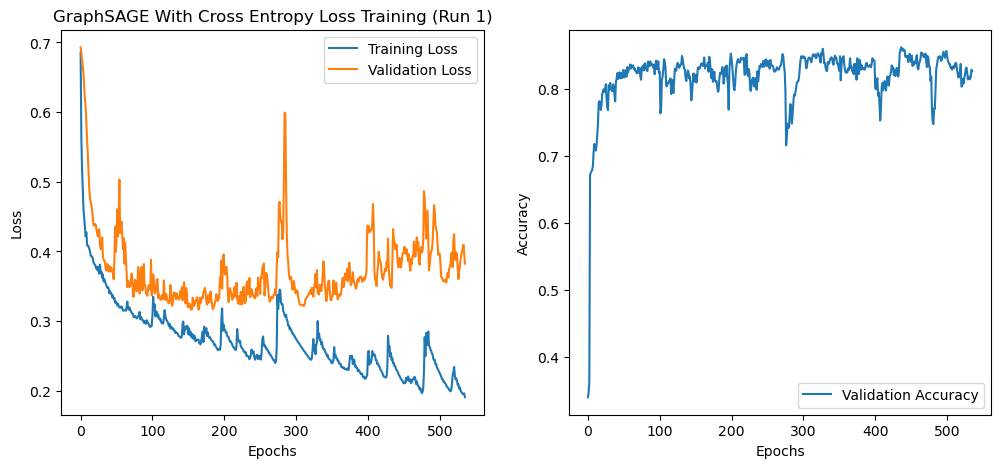

Run: 2/2, Model: GraphSAGE With Cross Entropy Loss, Epoch: 50, Loss: 0.3409, Val Loss: 0.3811, Val Accuracy: 0.8330, Val Precision: 0.7427, Val Recall: 0.7748, Val F1: 0.7584
Run: 2/2, Model: GraphSAGE With Cross Entropy Loss, Epoch: 100, Loss: 0.2985, Val Loss: 0.3355, Val Accuracy: 0.8302, Val Precision: 0.6939, Val Recall: 0.8915, Val F1: 0.7804
Run: 2/2, Model: GraphSAGE With Cross Entropy Loss, Epoch: 150, Loss: 0.2819, Val Loss: 0.3374, Val Accuracy: 0.8492, Val Precision: 0.7607, Val Recall: 0.8086, Val F1: 0.7839
Run: 2/2, Model: GraphSAGE With Cross Entropy Loss, Epoch: 200, Loss: 0.2620, Val Loss: 0.3540, Val Accuracy: 0.8551, Val Precision: 0.7663, Val Recall: 0.8226, Val F1: 0.7935
Run: 2/2, Model: GraphSAGE With Cross Entropy Loss, Epoch: 250, Loss: 0.2469, Val Loss: 0.3288, Val Accuracy: 0.8370, Val Precision: 0.7018, Val Recall: 0.9008, Val F1: 0.7890
Run: 2/2, Model: GraphSAGE With Cross Entropy Loss, Epoch: 300, Loss: 0.2321, Val Loss: 0.3514, Val Accuracy: 0.8626, Val

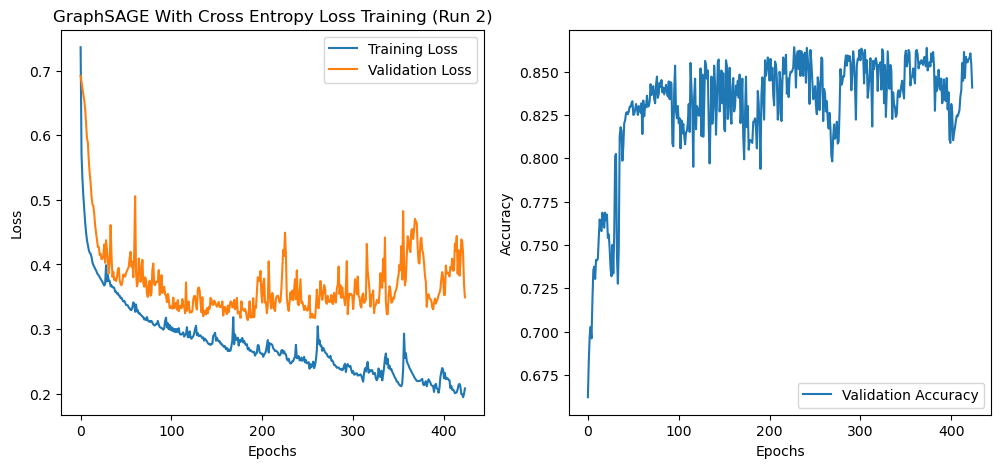


Successfully trained GraphSAGE With Cross Entropy Loss model (1/3) on chrome-run-01-without-centrality-metrics dataset

Training GraphSAGE With Focal Loss model (2/3) on chrome-run-01-without-centrality-metrics dataset...

Run: 1/2, Model: GraphSAGE With Focal Loss, Epoch: 50, Loss: 0.0870, Val Loss: 0.0947, Val Accuracy: 0.8196, Val Precision: 0.7364, Val Recall: 0.7270, Val F1: 0.7317
Run: 1/2, Model: GraphSAGE With Focal Loss, Epoch: 100, Loss: 0.0763, Val Loss: 0.0978, Val Accuracy: 0.7947, Val Precision: 0.8624, Val Recall: 0.4679, Val F1: 0.6067
Run: 1/2, Model: GraphSAGE With Focal Loss, Epoch: 150, Loss: 0.0707, Val Loss: 0.0850, Val Accuracy: 0.8476, Val Precision: 0.7904, Val Recall: 0.7480, Val F1: 0.7686
Run: 1/2, Model: GraphSAGE With Focal Loss, Epoch: 200, Loss: 0.0696, Val Loss: 0.0823, Val Accuracy: 0.8520, Val Precision: 0.7998, Val Recall: 0.7503, Val F1: 0.7742
Run: 1/2, Model: GraphSAGE With Focal Loss, Epoch: 250, Loss: 0.0720, Val Loss: 0.0887, Val Accuracy: 0.8

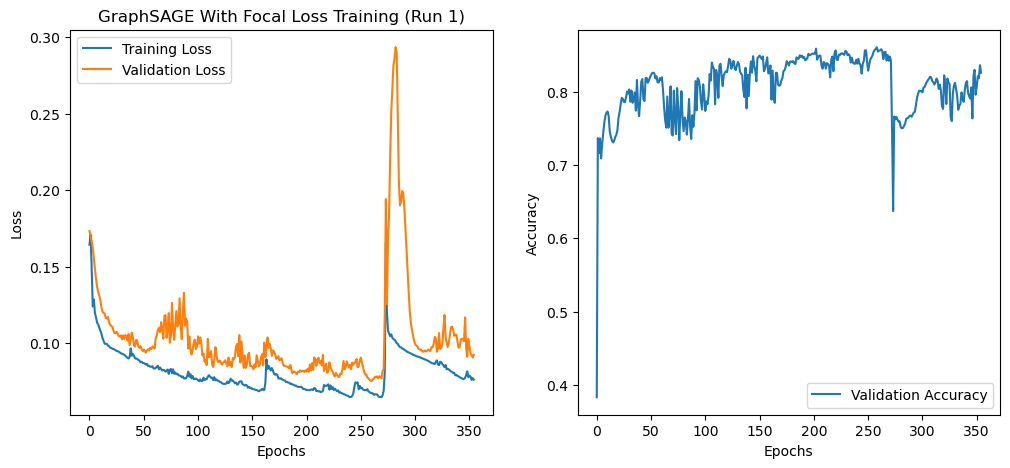

Run: 2/2, Model: GraphSAGE With Focal Loss, Epoch: 50, Loss: 0.0907, Val Loss: 0.0984, Val Accuracy: 0.8066, Val Precision: 0.7776, Val Recall: 0.5998, Val F1: 0.6772
Run: 2/2, Model: GraphSAGE With Focal Loss, Epoch: 100, Loss: 0.0780, Val Loss: 0.0882, Val Accuracy: 0.8279, Val Precision: 0.8194, Val Recall: 0.6301, Val F1: 0.7124
Run: 2/2, Model: GraphSAGE With Focal Loss, Epoch: 150, Loss: 0.0744, Val Loss: 0.0994, Val Accuracy: 0.8030, Val Precision: 0.9106, Val Recall: 0.4632, Val F1: 0.6141
Run: 2/2, Model: GraphSAGE With Focal Loss, Epoch: 200, Loss: 0.0739, Val Loss: 0.0900, Val Accuracy: 0.8105, Val Precision: 0.9019, Val Recall: 0.4936, Val F1: 0.6380
Run: 2/2, Model: GraphSAGE With Focal Loss, Epoch: 250, Loss: 0.0676, Val Loss: 0.0799, Val Accuracy: 0.8579, Val Precision: 0.7955, Val Recall: 0.7806, Val F1: 0.7880
Run: 2/2, Model: GraphSAGE With Focal Loss, Epoch: 300, Loss: 0.0706, Val Loss: 0.0806, Val Accuracy: 0.8555, Val Precision: 0.7871, Val Recall: 0.7853, Val F1: 

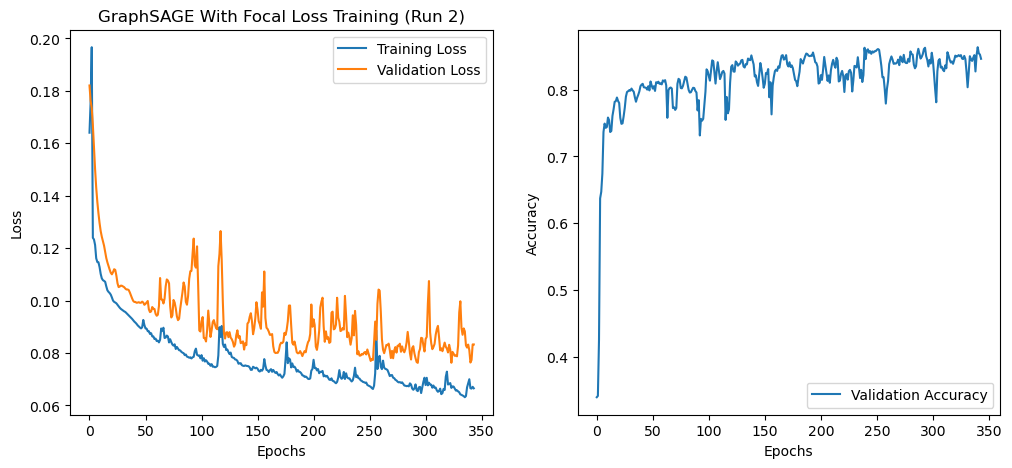


Successfully trained GraphSAGE With Focal Loss model (2/3) on chrome-run-01-without-centrality-metrics dataset

Training GraphSAGE With Hybrid Loss model (3/3) on chrome-run-01-without-centrality-metrics dataset...

Run: 1/2, Model: GraphSAGE With Hybrid Loss, Epoch: 50, Loss: 0.1948, Val Loss: 0.2089, Val Accuracy: 0.8164, Val Precision: 0.8379, Val Recall: 0.5671, Val F1: 0.6764
Run: 1/2, Model: GraphSAGE With Hybrid Loss, Epoch: 100, Loss: 0.1733, Val Loss: 0.1914, Val Accuracy: 0.8425, Val Precision: 0.8368, Val Recall: 0.6639, Val F1: 0.7404
Run: 1/2, Model: GraphSAGE With Hybrid Loss, Epoch: 150, Loss: 0.1574, Val Loss: 0.1818, Val Accuracy: 0.8527, Val Precision: 0.7888, Val Recall: 0.7713, Val F1: 0.7799
Run: 1/2, Model: GraphSAGE With Hybrid Loss, Epoch: 200, Loss: 0.1551, Val Loss: 0.1811, Val Accuracy: 0.8543, Val Precision: 0.8081, Val Recall: 0.7468, Val F1: 0.7762
Run: 1/2, Model: GraphSAGE With Hybrid Loss, Epoch: 250, Loss: 0.1524, Val Loss: 0.1803, Val Accuracy: 0.852

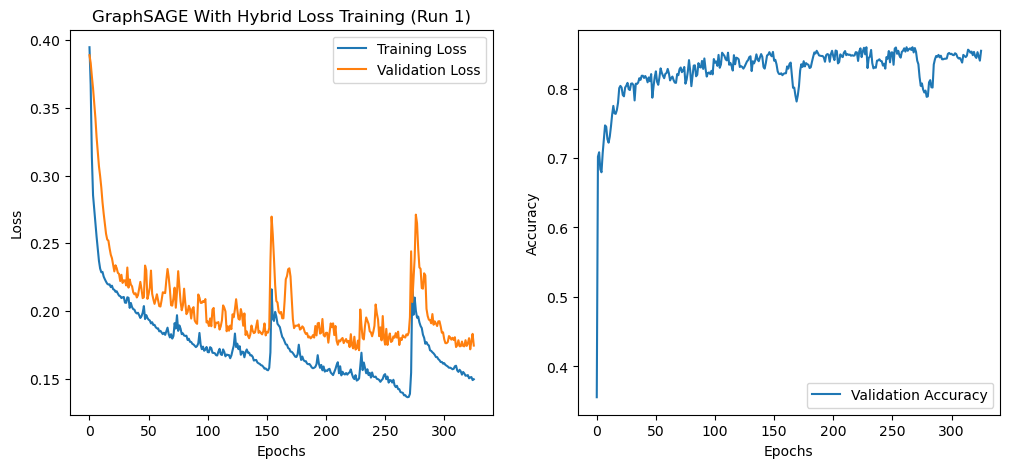

Run: 2/2, Model: GraphSAGE With Hybrid Loss, Epoch: 50, Loss: 0.1901, Val Loss: 0.2340, Val Accuracy: 0.7935, Val Precision: 0.8902, Val Recall: 0.4446, Val F1: 0.5930
Run: 2/2, Model: GraphSAGE With Hybrid Loss, Epoch: 100, Loss: 0.1671, Val Loss: 0.1901, Val Accuracy: 0.8413, Val Precision: 0.8054, Val Recall: 0.7001, Val F1: 0.7491
Run: 2/2, Model: GraphSAGE With Hybrid Loss, Epoch: 150, Loss: 0.1708, Val Loss: 0.1811, Val Accuracy: 0.8480, Val Precision: 0.7776, Val Recall: 0.7713, Val F1: 0.7745
Run: 2/2, Model: GraphSAGE With Hybrid Loss, Epoch: 200, Loss: 0.1702, Val Loss: 0.1876, Val Accuracy: 0.8413, Val Precision: 0.8452, Val Recall: 0.6499, Val F1: 0.7348
Run: 2/2, Model: GraphSAGE With Hybrid Loss, Epoch: 250, Loss: 0.1427, Val Loss: 0.1710, Val Accuracy: 0.8535, Val Precision: 0.7542, Val Recall: 0.8413, Val F1: 0.7954
Run: 2/2, Model: GraphSAGE With Hybrid Loss, Epoch: 300, Loss: 0.1478, Val Loss: 0.1839, Val Accuracy: 0.8508, Val Precision: 0.8189, Val Recall: 0.7176, Va

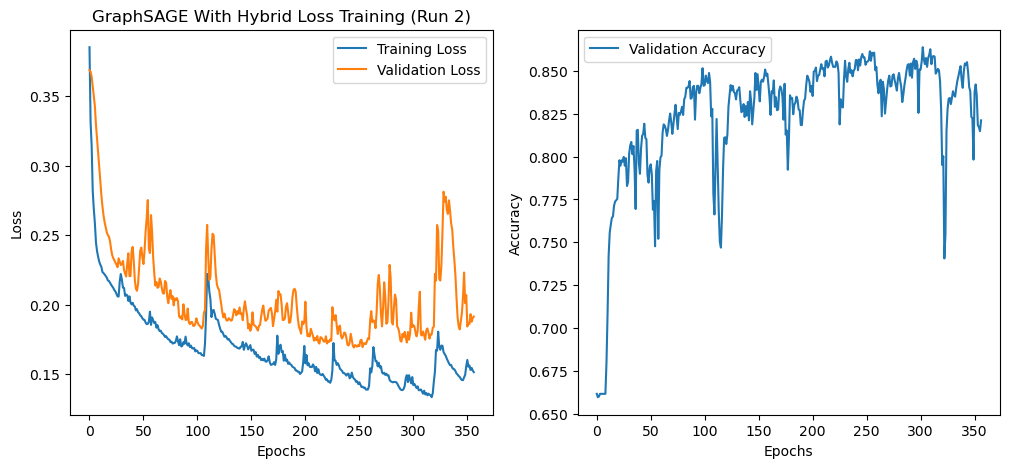


Successfully trained GraphSAGE With Hybrid Loss model (3/3) on chrome-run-01-without-centrality-metrics dataset


In [17]:
# Train the models
trained_models_criterias = train_model.train_validate(models_criterias, csv_file, num_runs=2)

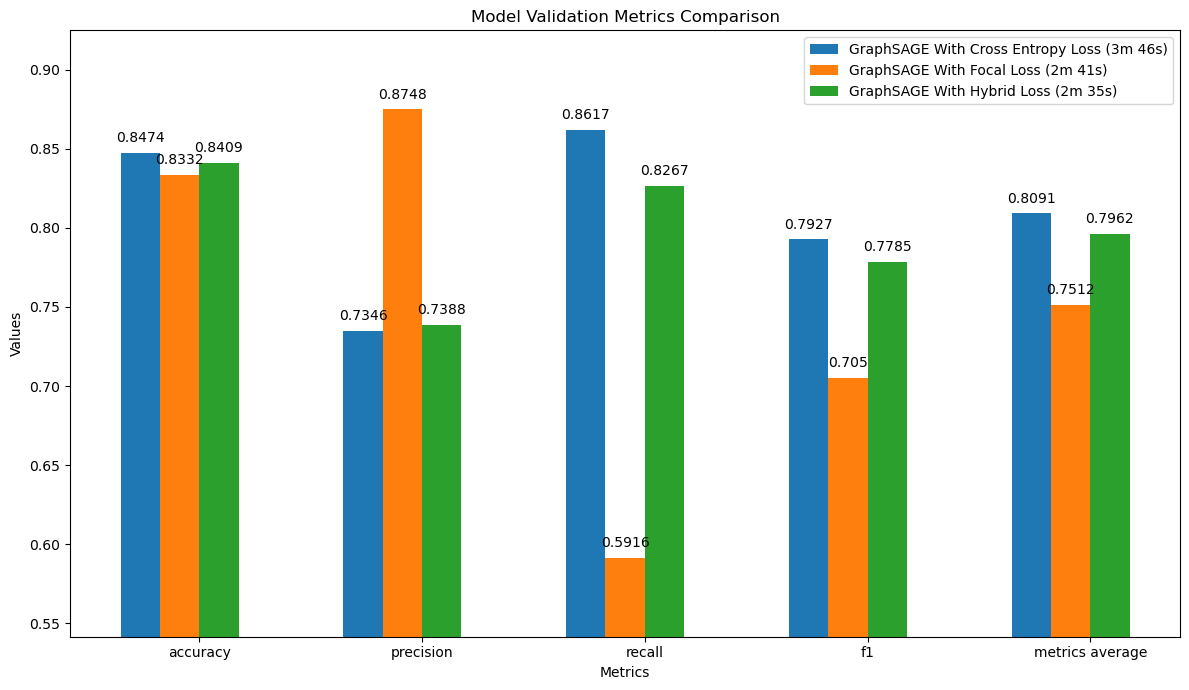

Standard Deviation for Accuracy: 0.006
Standard Deviation for Precision: 0.065
Standard Deviation for Recall: 0.120
Standard Deviation for F1: 0.038


In [18]:
# Compare the models
evaluate_model.plot_val_metrics(trained_models_criterias)